(example_4)=
# Example 4: Learning causal coupling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

```{admonition} Authors
:class: tip

- Lina Walkowiak, Aarhus University, Denmark ([202205493@post.au.dk](202205493@post.au.dk))
- Nicolas Legrand, Aarhus University, Denmark ([nicolas.legrand@cas.au.dk](nicolas.legrand@cas.au.dk))
```

In [331]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [332]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Callable, Dict, NamedTuple, Optional, Tuple

import jax
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from jax import Array, jit

from pyhgf import load_data
from pyhgf.math import gaussian_surprise, sigmoid, gaussian_density
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.model.network import Network
from pyhgf.typing import Edges
from pyhgf.utils import beliefs_propagation
from pyhgf.updates.prediction_error.continuous import continuous_node_prediction_error

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this notebook, we implement a model that incorporates causal coupling. 
We simulate two time series, where one has a causal influence on the other, where the magnitude of the influence is changing over time. The HGF model takes these two time series as inputs, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 


## Simulating a data set

We create two synthetic time series, $x_1$ and  $x_2$, where $x_1$ is an independent random walk and $x_2$ depends on $x_1$ with three varying levels of influence: strong, medium, and low. This approach allows us to model a dynamic causal relationship between the series, with dependency strengths changing in the three different phases. We add noise to each phase, with the noise level increasing and thereby the dependency weakens.

$$
\begin{align*} 
    x_1 & \sim \mathcal{N}(0.0, 0.2) \\
    x_2 & \sim \mathcal{N}(0.0, 0.2) \\
    x_2 & = x_2 + \alpha x_1
\end{align*} 
$$

In [333]:
np.random.seed(123)

# Parameters
n_samples = 10000

# Generate x_1 and x_2 as a random walk
x1 = np.cumsum(np.random.normal(0, 0.02, n_samples)) + 2.0
x2 = np.random.normal(0, 0.02, n_samples)

# Coupling vector
coupling = np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0, 0.2, 0.8, 0.0, 1.0]).repeat(
    n_samples / 10
)

# Update x_2 so it is influenced by x_1 according to the coupling vector
x2 = x2 + coupling * x1

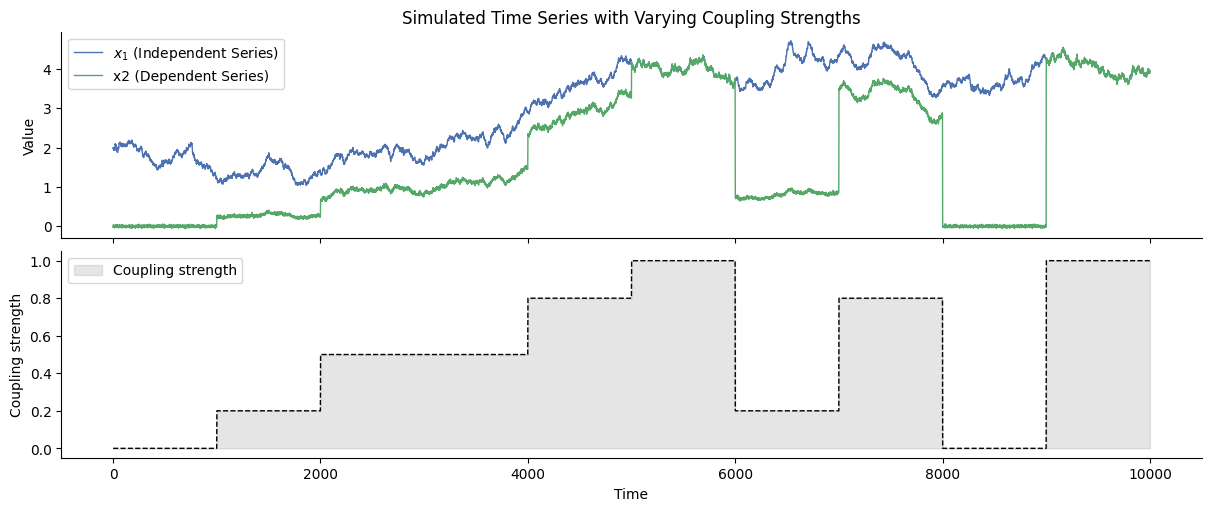

In [334]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
axs[0].plot(x1, label=r"$x_1$ (Independent Series)", color="#4c72b0", linewidth=1)
axs[0].plot(x2, label="x2 (Dependent Series)", color="#55a868", linewidth=1)
axs[0].set(
    title="Simulated Time Series with Varying Coupling Strengths", ylabel="Value"
)
axs[0].legend()

axs[1].plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs[1].fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs[1].set(xlabel="Time", ylabel="Coupling strength")
axs[1].legend()
sns.despine();

## Creating the network

Here, we initialize one network with two input state nodes. Each state node is influenced by a value parent. The two nodes are independent of each other.

In [335]:
# Initialize two independent HGFs for X1 and X2
non_causal_hgf = (
    Network()
    .add_nodes(precision=1e1, n_nodes=2)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)

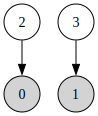

In [336]:
non_causal_hgf.plot_network()

In [337]:
# Input the time series
input_data = np.array([x1, x2]).T
non_causal_hgf.input_data(input_data=input_data);

Array(157040.83, dtype=float32)

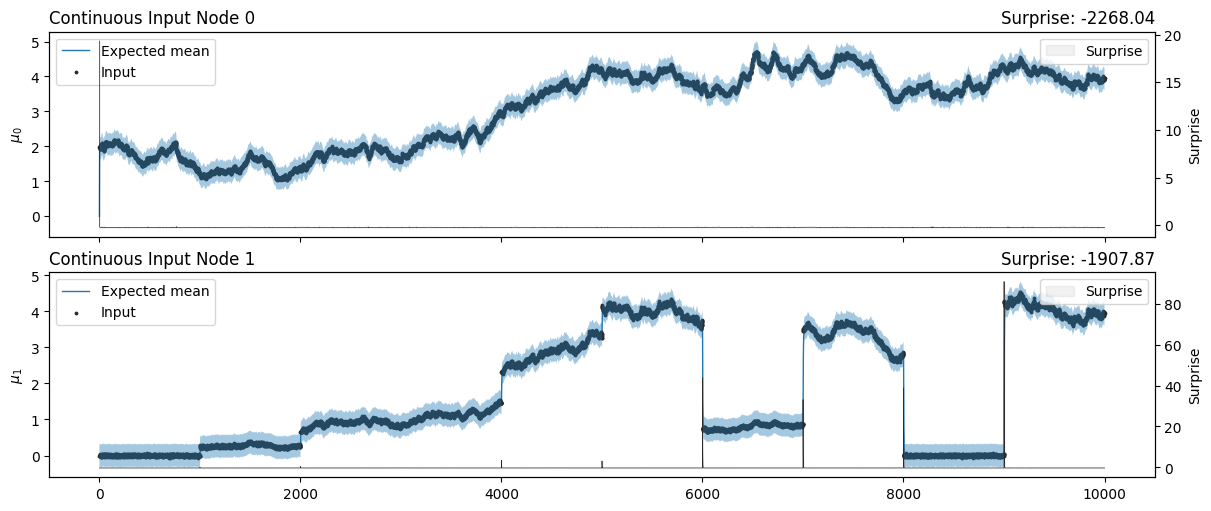

In [338]:
# Plot trajectories for each HGF
non_causal_hgf.plot_nodes(node_idxs=[0, 1]);
non_causal_hgf.surprise(response_function=first_level_gaussian_surprise).sum()


## Causal coupling model

In this section, we create a coupled HGF model to capture the causal influence of the variable $x_1$ on the variable $x_2$. This setup now implies learning the strength of a causal connection between $x_1$ and $x_2$, which should reflect the actual value used for the simulations above. We therefore use the same model as a starting point and will add an extra step in the update sequence to learn the causal coupling strength over time.

In [339]:
# Initialize a causal HGF
causal_hgf = (
    Network()
    .add_nodes(precision=1e1, n_nodes=2, tonic_volatility = 2)
    .add_nodes(value_children=0, precision=1e1)
    .add_nodes(value_children=1, precision=1e1)
)

### Add a causal connection between the two nodes

In [340]:
# Add the coupling strength in the node attributes
causal_hgf.attributes[0]["causal_coupling_children"] = jnp.array([0.0])

In [341]:
# Update the edges variable so it stores the index of the causal child
edges = list(causal_hgf.edges)
adjacency_list = edges[0]

In [342]:
# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

In [343]:
# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
causal_hgf.edges = tuple(edges)

### Create the causal update function

Now that the variables are in place in the network, we need to create a new update function that will estimate the causal strength between the two variables at each belief propagation.

In [344]:
@partial(jit, static_argnames=("node_idx", "edges"))
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
) -> Array:
    r"""Update the causal strength between this node and all causal children.

    Parameters
    ----------
    attributes :
        The attributes of the probabilistic nodes.
    node_idx :
        Pointer to the value parent node that will be updated.

    Returns
    -------
    attributes :
        The attributes of the probabilistic nodes.

    """
    # get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_precision = attributes[node_idx]["expected_precision"]

    # for all causal children, compute the new causal strength
    new_strengths = []
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):

        # get children's expected mean and precision
        child_expected_mean = attributes[causal_child_idx]["expected_mean"]
        child_expected_precision = attributes[causal_child_idx]["expected_precision"]

        child_surprise = gaussian_surprise(
            x=attributes[causal_child_idx]["mean"],
            expected_mean=child_expected_mean,
            expected_precision=child_expected_precision,
        )
        combined_surprise = gaussian_surprise(
            x=attributes[causal_child_idx]["mean"],
            expected_mean=child_expected_mean + parent_expected_mean,
            expected_precision=child_expected_precision + parent_expected_precision,
        )
        new_strengths.append(child_surprise - combined_surprise)

    # update the strengths vector
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes

In [345]:
# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()


## Fitting data and visualisation

In [346]:
causal_hgf.input_data(input_data=input_data);

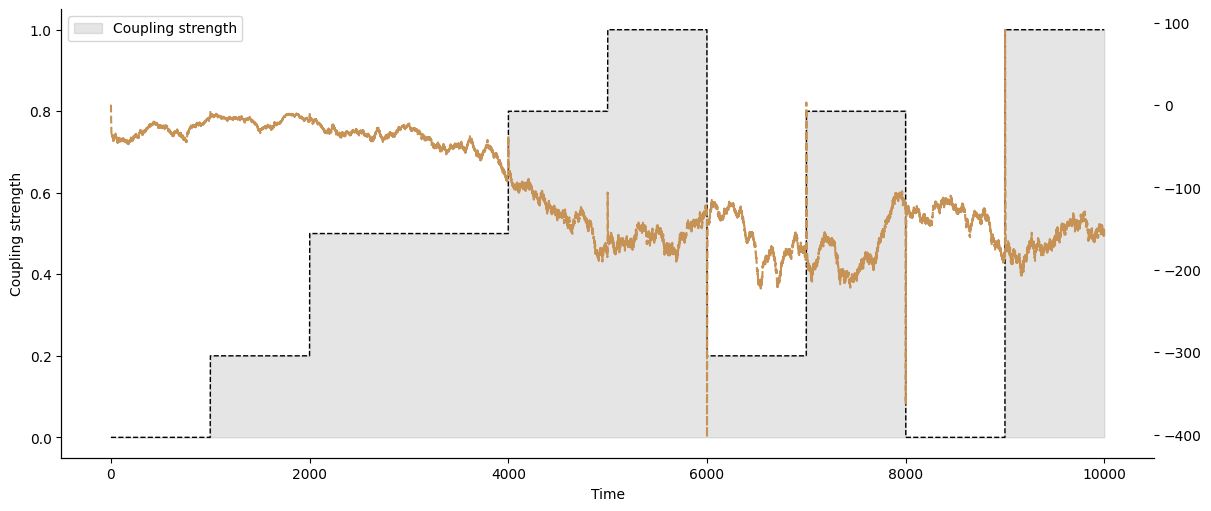

In [347]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"],
    label="Inferred coupling strength",
    color="#c69255",
    linestyle="--",
)




sns.despine();

### Update of the coupling strength 
The continuous_node_causal_strength function updates the causal coupling strength between a parent and its child nodes dynamically during belief propagation. The update rule combines the parent's state (reflected by the tanh of its mean to account for large values) and the child's precision-weighted prediction error, ensuring that changes in causal strength are proportional to both the parent's influence and the child's confidence in its prediction error. After updating, a sigmoid-like transformation rescales the strengths to keep them bounded between 0 and 1. 





In [348]:
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
    learning_rate: float = 10.0,
    temperature: float = 1.0,
) -> Array:
    r"""
Causal coupling strength update.

The causal coupling strength \( w_{ij} \) is updated as follows:

1. **Update**:
   
   .. math:: 
        w_{ij}^{t} = w_{ij}^{t-1} + \eta \cdot \Delta_j \cdot \text{tanh}(\mu_i)

   where:
   - \( \eta \) is the learning rate.
   - \( \mu_i \) is the parent's expected mean.
   - \( \Delta_j \) is the precision-weighted PE.

2. **Rescaling with Sigmoid- transformation**:
   
   .. math::
       w_{ij} = \frac{x^\text{temperature}}{x^\text{temperature} + (1 - x)^\text{temperature}}

   where \( \text{temperature} = 1 \).

Parameters
----------
attributes :
    The attributes of the probabilistic nodes.
edges :
    The edges of the network.
node_idx :
    Index of the parent node whose causal coupling strengths are being updated.
learning_rate :
    The learning rate \( \eta \) for updating the edge weights.

Returns
-------
attributes :
    The updated attributes of the probabilistic nodes, including updated causal coupling strengths.
"""
    # Validate inputs and check for errors
    if node_idx not in attributes:
        raise ValueError(f"Node index {node_idx} not found in attributes.")
    
    # Get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_mean_tanh = jnp.tanh(parent_expected_mean)

    # Initialize list for new strengths
    new_strengths = []

    # Iterate over each causal child to calculate new (raw) strengths
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):
        # Retrieve the prediction error and precision for the child
        prediction_error = attributes[causal_child_idx]["temp"]["value_prediction_error"]
        child_precision = attributes[causal_child_idx]["expected_precision"]

        # Compute precision-weighted PE
        precision_weighted_pe = prediction_error * child_precision

        # Update the strength for the edge between parent and child (raw update)
        update = learning_rate * precision_weighted_pe * parent_expected_mean_tanh
        raw_strength = strength + update

        # Rescale using the sigmoid-like transformation
        rescaled_strength = (raw_strength**temperature) / (
            raw_strength**temperature + (1 - raw_strength)**temperature
        )


        # Append the rescaled strength
        new_strengths.append(rescaled_strength)

    # Update causal coupling strengths for the parent node
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes


In [349]:
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()
causal_hgf.create_belief_propagation_fn()


In [350]:
causal_hgf.input_data(input_data=input_data);

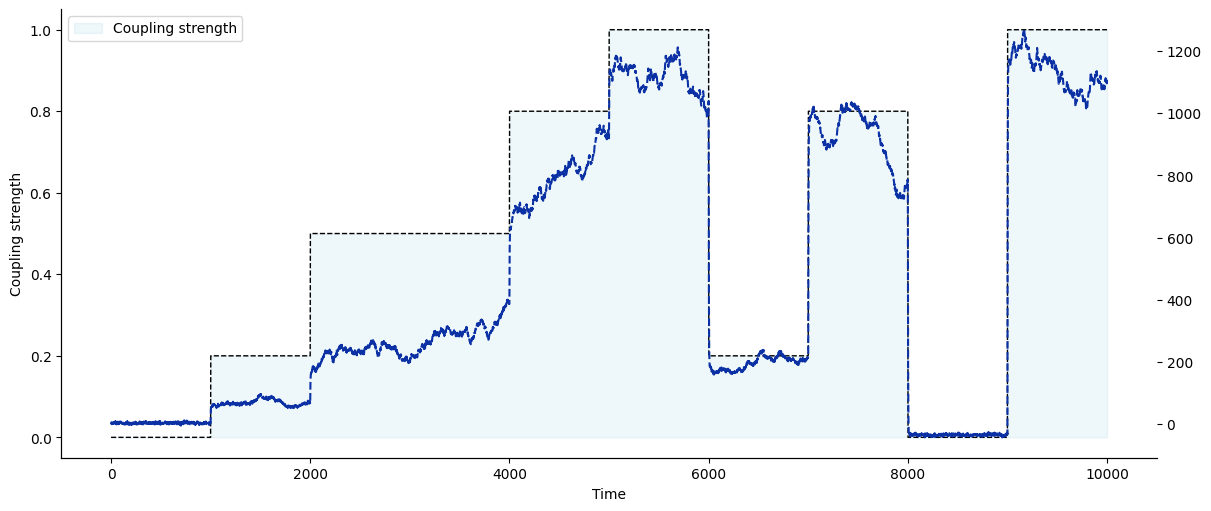

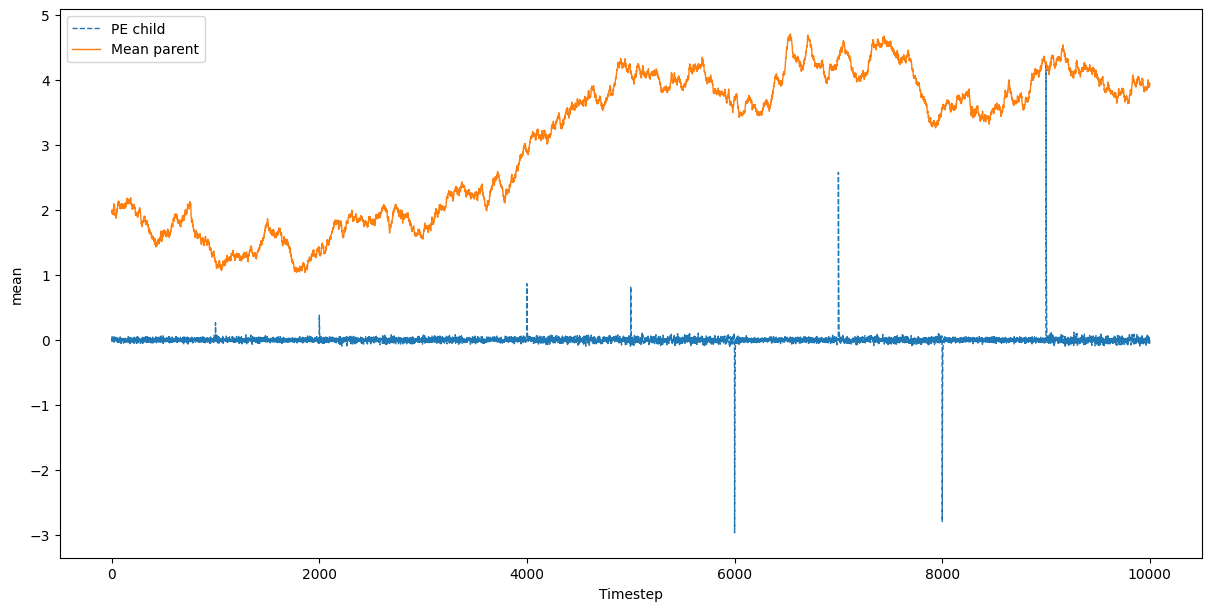

In [351]:
# Plot the trajectories
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="lightblue",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"], 
    label="Inferred coupling strength",
    color="#0B31A5",
    linestyle="--",
)

sns.despine();

# plot PE and mean over time
fig, axs = plt.subplots(figsize = (12, 6))

axs.plot(
    causal_hgf.node_trajectories[1]["temp"]['value_prediction_error'], 
    linestyle="--", 
    linewidth=1.0, 
    label="PE child"
)

axs.set(xlabel="Timestep", ylabel="PE")
axs.legend(loc="upper left")

axs.plot(
    causal_hgf.node_trajectories[0]['mean'], 
    linestyle="-", 
    linewidth=1.0, 
    label="Mean parent"
)

axs.set(xlabel="Timestep", ylabel="mean")
axs.legend(loc="upper left")

## Measuring freedom and control

The functions provided here serve as tools to measure the dependence between an agent's actions and the environmental states (as a proxy of freedom), as well as the influence of the agent's actions on future environmental states (a proxy of control). To quantify these dependencies, **KL divergence** is used as a measure of mutual information between Gaussian distributions. 
- The `construct_multivariate_gaussian_means_covariances` function creates a joint multivariate Gaussian distribution from a set of means, precisions, and correlations. 
- The `kl_divergence_multivariate_gaussian` function computes the KL divergence between two multivariate Gaussian distributions. 
- The `kl_divergence_univariate_gaussian` function computes the divergence between univariate Gaussians. 

Together, they are meant to capture the mutual information I(A; E) as well as the conditional mutual information I(S^t+1; A^t | S^t). 

In [352]:
def construct_multivariate_gaussian_means_covariances(means, precisions, correlations):
    """
    Construct a multivariate Gaussian distribution for multiple correlated nodes.
    
    Args:
        means (list): List of means for each node.
        precisions (list): List of precisions (inverse variances) for each node.
        correlations (2D array or list of lists): Symmetric matrix of correlation coefficients (n x n).
    
    Returns:
        mean: Joint mean vector.
        cov: Joint covariance matrix.
        precision: Joint precision matrix (inverse covariance).
    """
    # Convert correlations to array if not already done
    correlations = np.array(correlations)
    
    # Convert precisions to variances
    variances = [1 / p for p in precisions]
    std_devs = [np.sqrt(var) for var in variances]
    
    # Get mean vector
    mean = np.array(means)
    
    # Construct covariance matrix
    n = len(means)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i, j] = correlations[i, j] * std_devs[i] * std_devs[j]
    
    # Precision matrix
    precision = np.linalg.inv(cov)
    
    return mean, cov, precision


In [353]:
from scipy.linalg import inv, det

def kl_divergence_multivariate_gaussian(mean_p, cov_p, mean_q, cov_q):
    """
    Compute KL divergence between two multivariate Gaussians.
    
    Args:
        mean_p: Mean vector of distribution p.
        cov_p: Covariance matrix of distribution p.
        mean_q: Mean vector of distribution q.
        cov_q: Covariance matrix of distribution q.
    
    Returns:
        KL divergence D_KL(p || q).
    """
    d = mean_p.shape[0]
    cov_q_inv = np.linalg.inv(cov_q)
    
    # Devide the terms to enhance reading
    term1 = np.log(np.linalg.det(cov_q) / np.linalg.det(cov_p))
    term2 = -d
    term3 = np.trace(cov_q_inv @ cov_p)
    term4 = (mean_q - mean_p).T @ cov_q_inv @ (mean_q - mean_p)
    
    return 0.5 * (term1 + term2 + term3 + term4)


In [354]:
def kl_divergence_univariate_gaussian(mean_p, precision_p, mean_q, precision_q):
    """
    Compute the KL divergence between two univariate Gaussian distributions.

    Args:
        mean_p: Mean of the first Gaussian (P).
        precision_p: Precision (inverse variance) of the first Gaussian (P).
        mean_q: Mean of the second Gaussian (Q).
        precision_q: Precision (inverse variance) of the second Gaussian (Q).

    Returns:
        KL divergence D_KL(P || Q).
    """
    # Convert precision to variance
    variance_p = 1 / precision_p
    variance_q = 1 / precision_q
    
    # Compute KL divergence
    kl_divergence = 0.5 * (
        np.log(precision_q / precision_p)  
        - 1                               
        + precision_p / precision_q      
        + precision_q * (mean_p - mean_q)**2 
    )
    return kl_divergence

In [355]:
def get_correlation_matrix(network):
    """
    Extract the correlation matrix of the sufficient statistics trajectories.

    Parameters
    ----------
    network : Network
        An instance of the HGF model.

    Returns
    -------
    correlation_mat : pd.DataFrame
        DataFrame containing the correlation matrix of model trajectories.
    """
    # Convert network trajectories to pandas DataFrame
    trajectories_df = network.to_pandas()
    
    # Filter relevant columns for sufficient statistics (means, expected, surprise)
    trajectories_df = pd.concat(
        [
            trajectories_df[["time"]],
            trajectories_df[
                [
                    f"x_{i}_mean"
                    for i in range(len(network.edges))
                    if i in network.input_idxs
                ]
            ],
            trajectories_df.filter(regex="expected"),
            trajectories_df.filter(regex="surprise"),
        ],
        axis=1,
    )

    # Compute correlation matrix
    correlation_mat = trajectories_df.corr()

    return correlation_mat



In [356]:
# Get means and precisions for the nodes of interest
mean_0 = causal_hgf.node_trajectories[0]['mean'][2]
precision_0 = causal_hgf.node_trajectories[0]['precision'][2]

mean_1 = causal_hgf.node_trajectories[1]['mean'][2]
precision_1 = causal_hgf.node_trajectories[1]['precision'][5]

mean_2 = causal_hgf.node_trajectories[2]['mean'][5]
precision_2 = causal_hgf.node_trajectories[2]['precision'][5]

mean_3 = causal_hgf.node_trajectories[3]['mean'][5]
precision_3 = causal_hgf.node_trajectories[3]['precision'][5]

# Get correlations between nodes from the matrxi as defined above
# This is over all time steps, maybe this should be specific to the time point 
correlation_mat = get_correlation_matrix(causal_hgf)

# Extract correlations
rho_01 = correlation_mat.loc["x_0_expected_mean", "x_1_expected_mean"]
rho_23 = correlation_mat.loc["x_2_expected_mean", "x_3_expected_mean"]

# Construct multivariate Gaussian for each pair of nodes
# Node 1 and Node 3
mean_13, cov_13, precision_13 = construct_multivariate_gaussian_means_covariances(
    [mean_1, mean_3],
    [precision_1, precision_3],
    [[1.0, rho_01], [rho_01, 1.0]]
)

# Node 0 and Node 2
mean_02, cov_02, precision_02 = construct_multivariate_gaussian_means_covariances(
    [mean_0, mean_2],
    [precision_0, precision_2],
    [[1.0, rho_23], [rho_23, 1.0]]
)

# Step 4: Compute KL divergence between the two pairs
kl_13_02 = kl_divergence_multivariate_gaussian(mean_13, cov_13, mean_02, cov_02)

print(f"KL Divergence between [Node 1, Node 3] and [Node 0, Node 2]: {kl_13_02}")


KL Divergence between [Node 1, Node 3] and [Node 0, Node 2]: 51.151569936459644


In [357]:
divergences = []
for t in range(len(causal_hgf.node_trajectories[0]['mean'])): 
    mean_0 = causal_hgf.node_trajectories[0]['mean'][t]
    precision_0 = causal_hgf.node_trajectories[0]['precision'][t]

    mean_1 = causal_hgf.node_trajectories[1]['mean'][t]
    precision_1 = causal_hgf.node_trajectories[1]['precision'][t]

    mean_2 = causal_hgf.node_trajectories[2]['mean'][t]
    precision_2 = causal_hgf.node_trajectories[2]['precision'][t]

    mean_3 = causal_hgf.node_trajectories[3]['mean'][t]
    precision_3 = causal_hgf.node_trajectories[3]['precision'][t]

    rho_01 = correlation_mat.loc["x_0_expected_mean", "x_1_expected_mean"]
    rho_23 = correlation_mat.loc["x_2_expected_mean", "x_3_expected_mean"]


    mean_13, cov_13, precision_13 = construct_multivariate_gaussian_means_covariances(
    [mean_1, mean_3],
    [precision_1, precision_3],
    [[1.0, rho_01], [rho_01, 1.0]]
    )
    mean_02, cov_02, precision_02 = construct_multivariate_gaussian_means_covariances(
    [mean_0, mean_2],
    [precision_0, precision_2],
    [[1.0, rho_23], [rho_23, 1.0]]
    )
    kl_13_02 = kl_divergence_multivariate_gaussian(mean_13, cov_13, mean_02, cov_02)
    divergences.append(kl_13_02)

    

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_11255/698418042.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


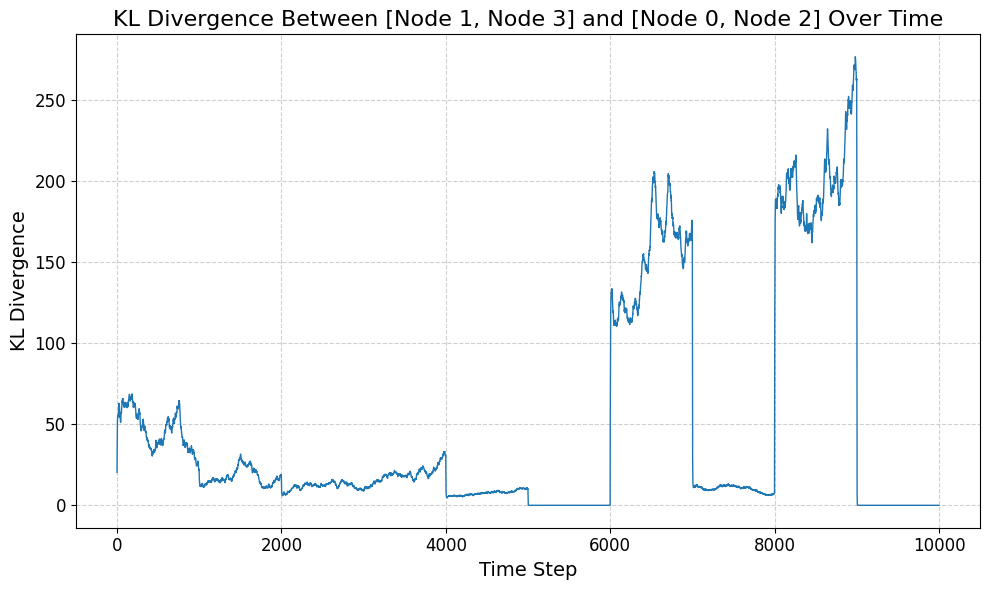

In [358]:
# Plot KL divergences over time
plt.figure(figsize=(10, 6))  # Set a nice figure size
plt.plot(range(len(divergences)), divergences, linestyle='-', linewidth=1)

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.title("KL Divergence Between [Node 1, Node 3] and [Node 0, Node 2] Over Time", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_11255/3650858724.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


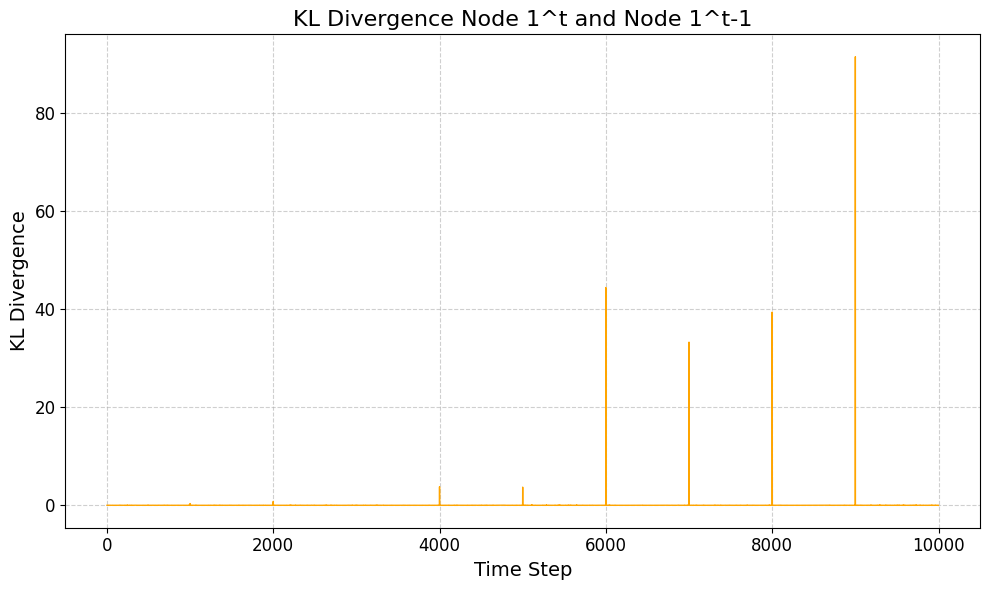

In [359]:
# KL for node 1 and node 1 t+1 (MI(S^{t+1}|S^t))
mean_t_1 = causal_hgf.node_trajectories[1]['mean'][1:] 
mean_t = causal_hgf.node_trajectories[1]['mean'][:-1]
precision_t_1 = causal_hgf.node_trajectories[1]['precision'][1:] 
precision_t = causal_hgf.node_trajectories[1]['precision'][:-1]

kl_node_1 = kl_divergence_univariate_gaussian(mean_t_1, precision_t_1, mean_t, precision_t)

plt.figure(figsize=(10, 6))  # Set a nice figure size
plt.plot(kl_node_1, linestyle='-', linewidth=1, color='orange')

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("KL Divergence", fontsize=14)
plt.title("KL Divergence Node 1^t and Node 1^t-1", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



## Agent comparison

### Free agent

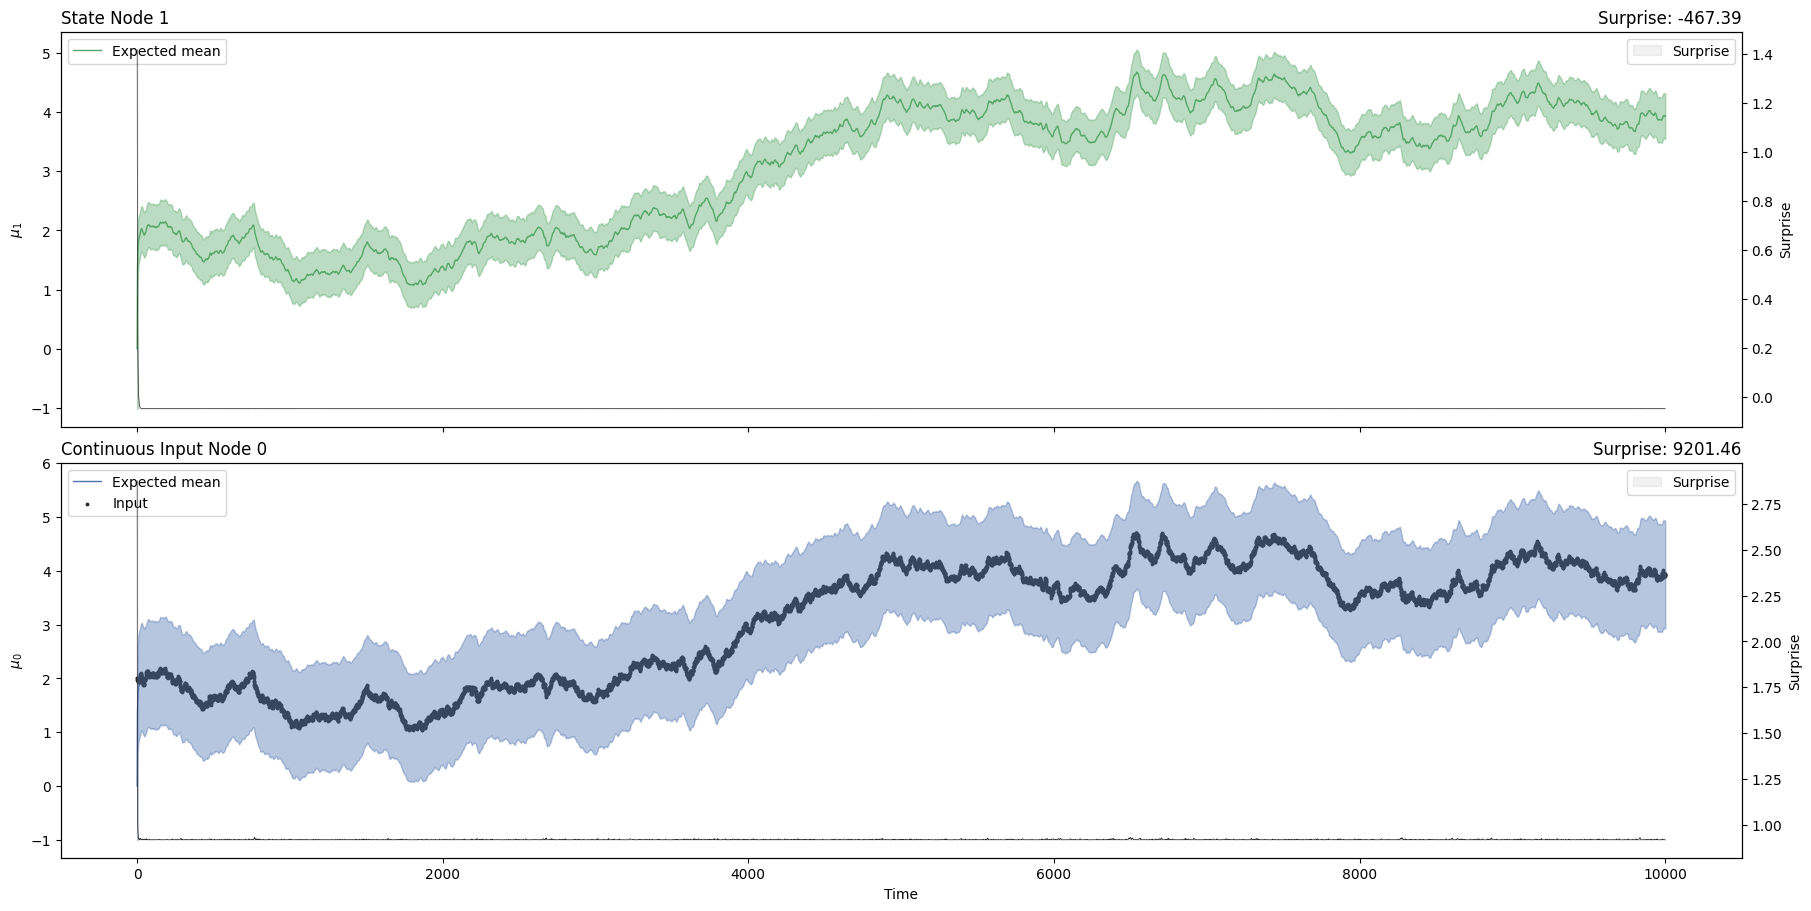

In [360]:
free_agent = (
    Network()
    .add_nodes(kind = "continuous-state", n_nodes=1)
    .add_nodes(value_children=0))

attributes, edges, update_sequence = (
    free_agent.get_network()
)

# Ball positions as input
free_agent.input_data(input_data=x1)
free_agent.plot_trajectories();

# For the free agent, actions are randomly sampled from between -1 and 1
action_range = (-1, 1)  
# Generate random actions for each timestep
random_actions = np.random.uniform(low=action_range[0], high=action_range[1], size=n_samples)



Text(0.5, 0, 'Trials')

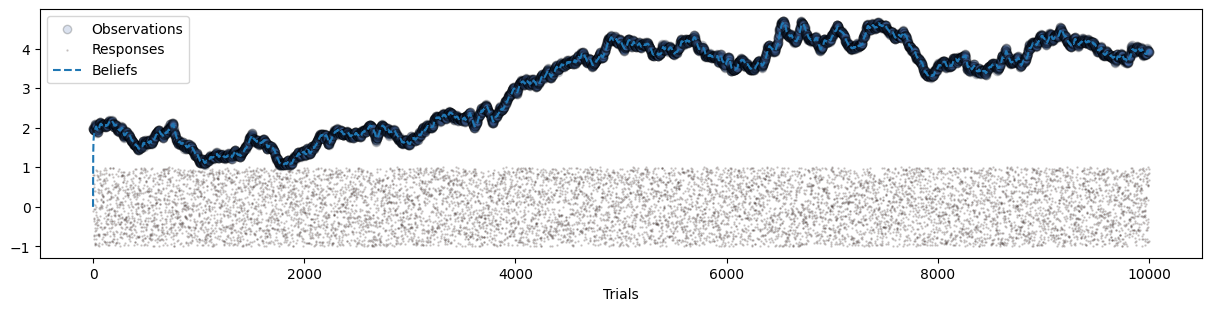

In [361]:
plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(x1)), x1, label="Observations", color="#4c72b0", edgecolor="k", alpha=.2)
plt.scatter(np.arange(len(random_actions)), random_actions, label="Responses", color="#c96450", alpha=.2, edgecolor="k", s = 0.5)
plt.plot(free_agent.node_trajectories[0]["expected_mean"], label="Beliefs", linestyle="--")
plt.legend()
plt.xlabel("Trials")

### Partly free agent

Text(0.5, 0, 'Trials')

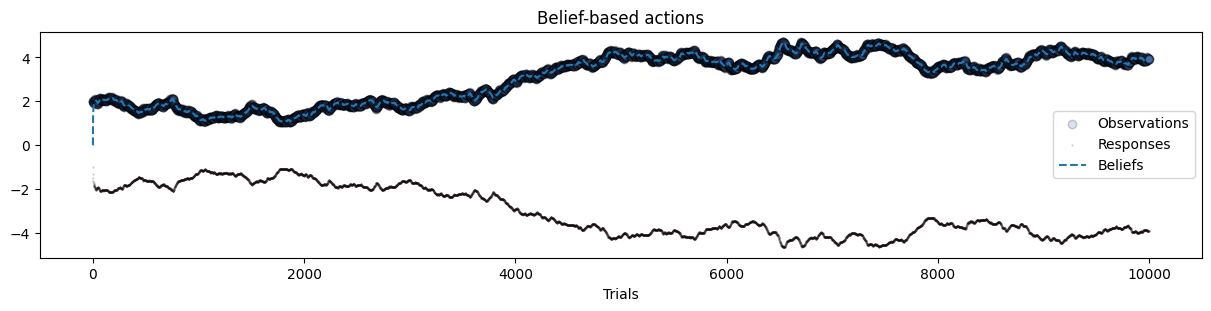

In [385]:
partly_agent = (
    Network()
    .add_nodes(kind = "continuous-state", n_nodes=1)
    .add_nodes(value_children=0)).create_belief_propagation_fn()

attributes, edges, update_sequence = (
    partly_agent.get_network()
)

# Ball positions as input
partly_agent.input_data(input_data=x1)

# Initialize storage for actions
partly_actions = []

beliefs = partly_agent.node_trajectories[0]["expected_mean"]

# Simple decision rule: directly use the belief to compute actions
partly_actions = -1.0 * beliefs  # Actions proportional to the belief

# Plot actions
plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(x1)), x1, label="Observations", color="#4c72b0", edgecolor="k", alpha=.2)
plt.scatter(np.arange(len(partly_actions)), partly_actions, label="Responses", color="#c44e52", alpha=.2, edgecolor="k", s=0.3)
plt.plot(partly_agent.node_trajectories[0]["expected_mean"], label="Beliefs", linestyle="--")
plt.legend()
plt.title('Belief-based actions')
plt.xlabel("Trials")

### Action influence

array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

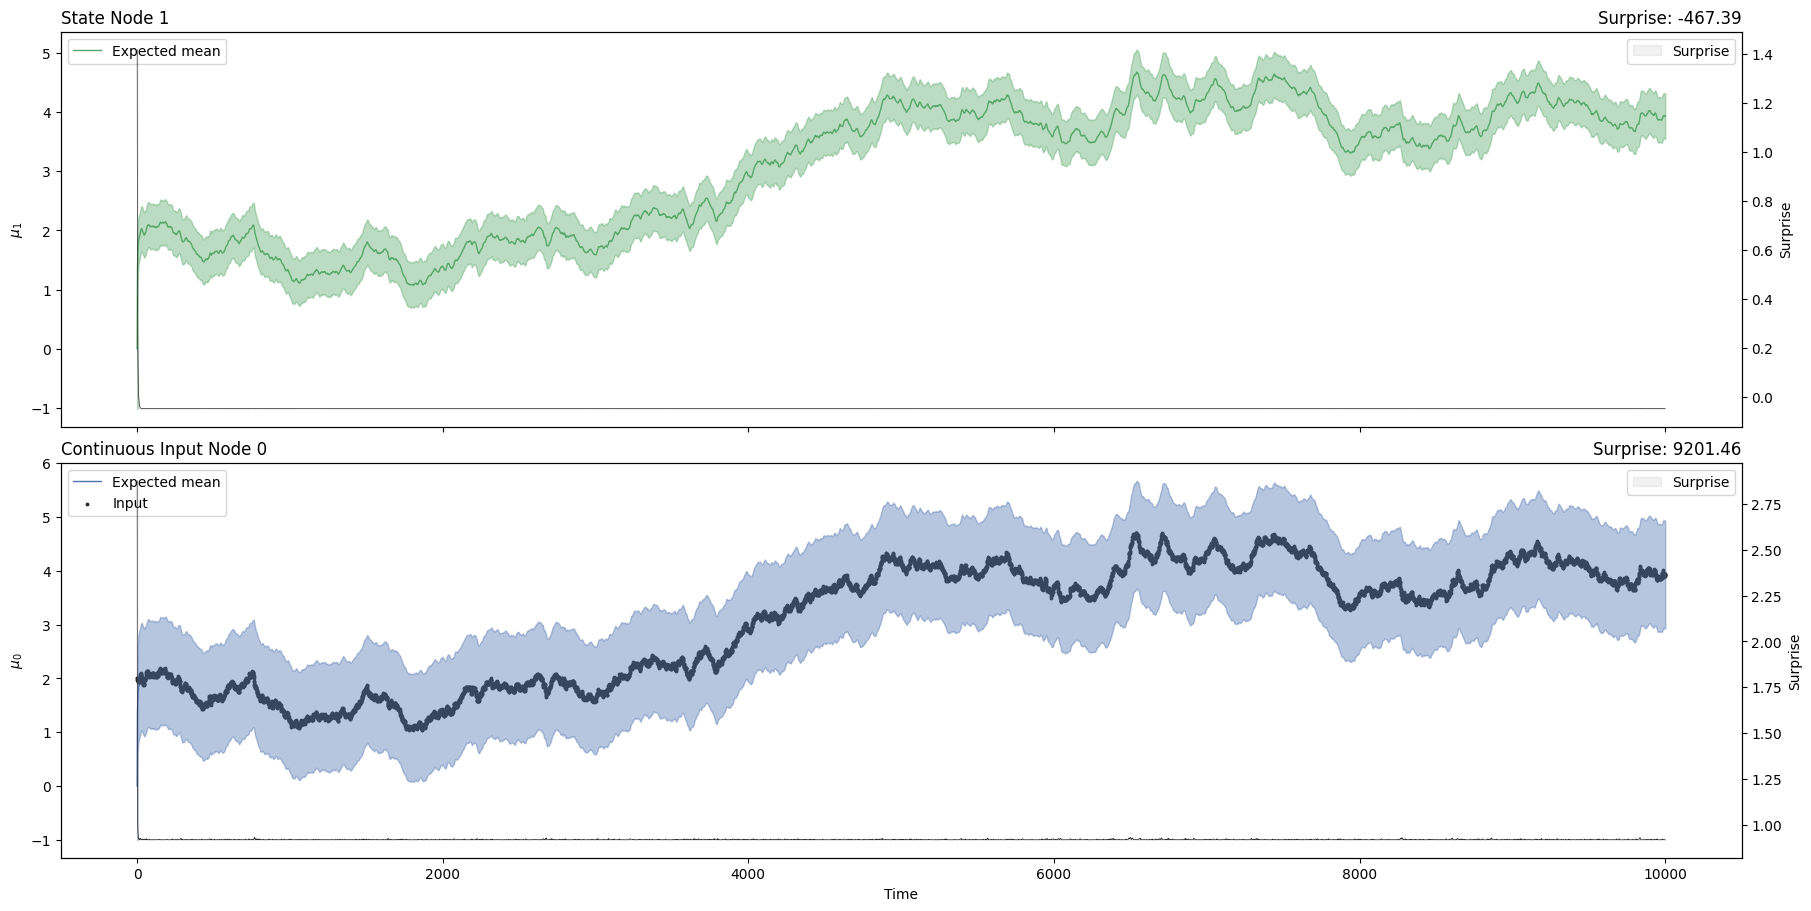

In [364]:
# Udpate inputs iteravily 
action_range = (-1, 1)
action_factor = 1.0
actions = [0.0]  # first action as 0 
updated_input_data = x1.copy()

# Extract network parameters for beliefs_propagation
attributes, edges, update_sequence = free_agent.get_network()
input_idxs = free_agent.input_idxs


# Iterate over timesteps
for t in range(1, n_samples):
    # Take inout data and update based on action and action factor
    updated_input_data[t] += action_factor * actions[-1]
    
    
    # update the network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(*updated_input_data, 1.0),  
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=free_agent.input_idxs
    )
    

    # Sample new action (random for now)
    action = np.random.uniform(low=action_range[0], high=action_range[1])
    actions.append(action)


actions = jnp.asarray(actions)  # vector of responses

# Plot results (if applicable)
free_agent.plot_trajectories()


## Decisions based on beliefs

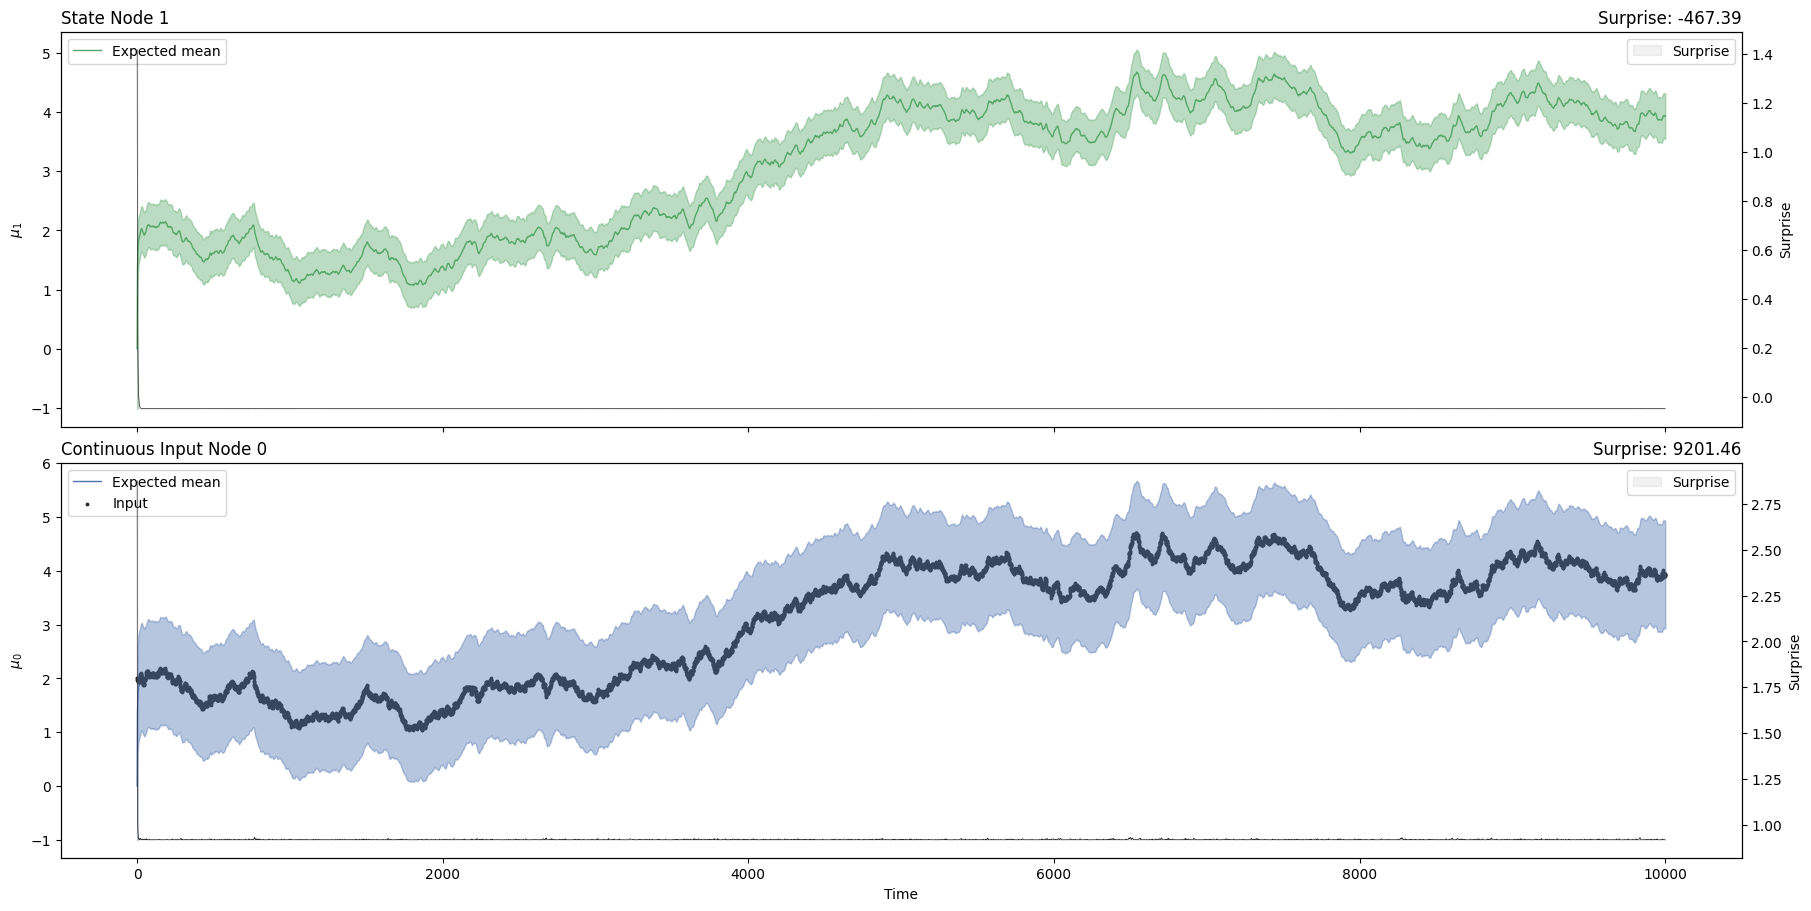

In [366]:
medium_agent = (
    Network()
    .add_nodes(kind = "continuous-state", n_nodes=1)
    .add_nodes(value_children=0))

# Ball positions as input
medium_agent.input_data(input_data=x1)
medium_agent.plot_trajectories();

In [367]:
# Define proportional gain
k = 0.5  # action-belief sensitivity 

# Extract the belief about the ball's position from the agent's lowest level
beliefs = medium_agent.node_trajectories[0]["expected_mean"] 

# Compute actions to counteract deviation from 0
control_actions = -k * beliefs


Text(0.5, 0, 'Trials')

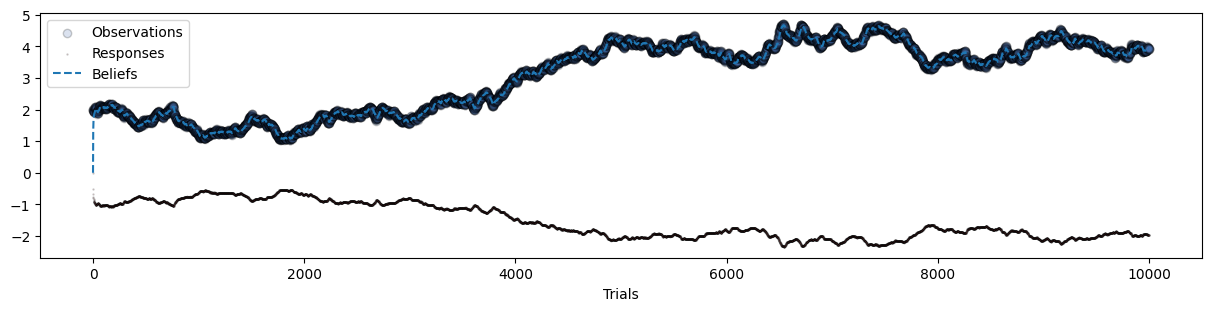

In [368]:
plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(x1)), x1, label="Observations", color="#4c72b0", edgecolor="k", alpha=.2)
plt.scatter(np.arange(len(control_actions)), control_actions, label="Responses", color="#c44e52", alpha=.2, edgecolor="k", s = 0.5)
plt.plot(medium_agent.node_trajectories[0]["expected_mean"], label="Beliefs", linestyle="--")
plt.legend()
plt.xlabel("Trials")

## System configuration

In [369]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Dec 02 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
numpy     : 1.26.0
scipy     : 1.14.1
pandas    : 2.2.3
pyhgf     : 0.0.0
matplotlib: 3.9.2
IPython   : 8.29.0
jax       : 0.4.35
seaborn   : 0.13.2

Watermark: 2.5.0

